## Comparative Bank Case Study


### Configure WRDS Connection

In [1]:
import wrds
db = wrds.Connection()

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


## Bank Codes

In [2]:
bank_info = {
    "Citi": 7213,
    "US Bank": 6548,
    "PNC": 6384,
    "Truist": 9846,
    "FifthThird": 6672,
    "Regions": 12368,
    "KeyBank": 17534,
    "Citizens": 57957,
    "Valley": 9396,
    "BankOfHawaii": 18053,
    # optional “run” case studies:
    "SiliconValley": 24735,
    "FirstRepublic": 59017,
}

fdic_certs = list(bank_info.values())
cert_list_sql = ", ".join(str(c) for c in fdic_certs)
cert_list_sql

'7213, 6548, 6384, 9846, 6672, 12368, 17534, 57957, 9396, 18053, 24735, 59017'

## MAIN DATA QUERY

⸻

Call Report–Based Liquidity and Funding Panel

This query constructs a quarterly, bank-level panel from WRDS Call Report data for a single FDIC-insured institution. For each report date, the query selects the latest available submission to ensure that amended filings are reflected. All monetary values are reported in thousands of U.S. dollars, consistent with Call Report conventions.

The panel is designed to support analysis of bank liquidity, funding structure, and deposit behavior, with a specific focus on (i) consolidated balance-sheet size and capital, (ii) the composition of deposits and non-deposit funding, and (iii) liquid asset holdings that approximate high-quality liquid assets (HQLA).

Consolidated balance-sheet measures

Core balance-sheet variables are drawn from consolidated (RCFD/RCFN) schedules to align with an FFIEC-031–style view of the banking organization. These include total assets, net loans and leases, total equity capital, total liabilities plus minority interest, and consolidated total deposits. This consolidated perspective facilitates internally consistent liquidity ratios and funding comparisons over time.

Funding structure and deposits

Funding is decomposed into:
	•	Core deposit funding, measured by consolidated total deposits (RCFN2200), and
	•	Wholesale/non-deposit funding, proxied by federal funds purchased and securities sold under agreements to repurchase (RCFD2800) and other borrowed money (RCFD3190).

To support heterogeneity in deposit run-off and interest-rate sensitivity, the query also extracts a domestic deposit split from RCON schedules, separating noninterest-bearing deposits (RCON6631) from interest-bearing deposits (RCON6636). This domestic decomposition can be combined with consolidated deposit totals to model differential deposit behavior.

Liquidity and HQLA building blocks

Liquid asset holdings are measured using standard Call Report categories commonly employed as HQLA proxies: cash and balances due from depository institutions, interest-bearing balances, held-to-maturity securities, available-for-sale debt securities, and trading assets. Together, these variables support the construction of simple liquidity buffers and liquidity ratios relative to assets or runnable funding.

⸻

Variable definitions

| Variable | Source table | Call code | Description |
|---|---:|---|---|
| report_date | RCFD_1 | WRDSREPORTDATE | Call Report reference date |
| fdic_cert | RCFD_1 | RSSD9050 | FDIC certificate number |
| rssd_id | RCFD_1 | RSSD9001 | RSSD identifier |
| total_assets | RCFD_2 | RCFD2170 | Total consolidated assets |
| total_loans | RCFD_2 | RCFD2122 | Loans and leases, net |
| total_equity | RCFD_2 | RCFD3210 | Total equity capital |
| total_liabs_minority | RCFD_2 | RCFD2948 | Total liabilities + minority interest |
| total_deposits | RCFN_1 | RCFN2200 | Total consolidated deposits |
| fedfunds_purchased_repos | RCFD_1 | RCFD2800 | Federal funds purchased & repos |
| other_borrowed_money | RCFD_1 | RCFD3190 | Other borrowed money |
| cash_and_balances | RCFD_1 | RCFD0010 | Cash & balances due from depository institutions |
| interest_bearing_balances | RCFD_1 | RCFD0071 | Interest-bearing balances |
| securities_htm_total | RCFD_1 | RCFD1754 | Held-to-maturity securities, total |
| securities_afs_total | RCFD_1 | RCFD1773 | Available-for-sale debt securities, total |
| trading_assets_total | RCFD_2 | RCFD3545 | Trading assets, total |
| total_deposits_domestic | RCON_2 | RCON2200 | Total domestic deposits |
| nonint_deposits_domestic | RCON_2 | RCON6631 | Noninterest-bearing domestic deposits |
| intbearing_deposits_domestic | RCON_2 | RCON6636 | Interest-bearing domestic deposits |

This panel provides a consistent foundation for modeling deposit run‑off, funding substitution, and liquidity buffers relative to runnable funding and consolidated assets.

In [64]:
import wrds
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1. Connect + choose a bank
# -----------------------------

FDIC_CERT = 7213  # Citibank

# -----------------------------
# 2. WRDS query: assets, deposits, wholesale funding
# -----------------------------
query = f"""
    WITH latest_submissions AS (
        SELECT
            rssd9050,
            wrdsreportdate,
            MAX(rssdsubmissiondate) AS max_submission
        FROM bank.wrds_call_rcfd_1
        WHERE rssd9050 IN ({FDIC_CERT})
        GROUP BY rssd9050, wrdsreportdate
    )
    SELECT
        /* ============================
           IDENTIFIERS
           ============================ */
        r1.wrdsreportdate              AS report_date,
        r1.rssd9050                    AS fdic_cert,
        r1.rssd9001                    AS rssd_id,           -- RSSD ID (not ABA)

        /* ============================
           CORE BALANCE SHEET (CONSOLIDATED)
           ============================ */
        r2.rcfd2170                    AS total_assets,          -- TOTAL ASSETS (RCFD2170)
        r2.rcfd2122                    AS total_loans,           -- LOANS & LEASES, NET (RCFD2122)
        r2.rcfd3210                    AS total_equity,          -- EQUITY CAPITAL (RCFD3210)
        r2.rcfd2948                    AS total_liabs_minority,  -- LIABS + MINORITY INTEREST (RCFD2948)

        /* ============================
           TOTAL DEPOSITS (CONSOLIDATED)
           ============================ */
        rdep.rcfn2200                  AS total_deposits,        -- TOTAL DEPOSITS (RCFN2200)

        /* ============================
           LIQUID ASSETS / HQLA BUILDING BLOCKS (CONSOLIDATED)
           ============================ */
        r1.rcfd0010                    AS cash_and_balances,         -- CASH & BALANCES DUE (RCFD0010)
        r1.rcfd0071                    AS interest_bearing_balances, -- INT-BEARING BALANCES (RCFD0071)
        r1.rcfd1754                    AS securities_htm_total,      -- HTM SECURITIES; TOTAL (RCFD1754)
        r1.rcfd1773                    AS securities_afs_total,      -- AFS DEBT SECURITIES; TOTAL (RCFD1773)
        r2.rcfd3545                    AS trading_assets_total,      -- TRADING ASSETS; TOTAL (RCFD3545)

        /* ============================
           WHOLESALE / NON-DEPOSIT FUNDING (CONSOLIDATED)
           ============================ */
        r1.rcfd2800                    AS fedfunds_purchased_repos,  -- FED FUNDS PURCHASED & REPOS (RCFD2800)
        r1.rcfd3190                    AS other_borrowed_money,      -- OTHER BORROWED MONEY (RCFD3190)

        /* ============================
           DOMESTIC DEPOSITS (RCON)
           ============================ */
        rcon2.rcon2200                 AS total_deposits_domestic,     -- TOTAL DOMESTIC DEPOSITS (RCON2200)
        rcon2.rcon6631                 AS nonint_deposits_domestic,    -- NONINTEREST-BEARING (RCON6631)
        rcon2.rcon6636                 AS intbearing_deposits_domestic -- INTEREST-BEARING (RCON6636)


    FROM bank.wrds_call_rcfd_1 r1
    INNER JOIN latest_submissions ls
        ON  r1.rssd9050           = ls.rssd9050
        AND r1.wrdsreportdate     = ls.wrdsreportdate
        AND r1.rssdsubmissiondate = ls.max_submission

    /* Consolidated balance sheet extension (RCFD_2) */
    LEFT JOIN bank.wrds_call_rcfd_2 r2
        ON  r1.rssd9050           = r2.rssd9050
        AND r1.wrdsreportdate     = r2.wrdsreportdate
        AND r1.rssdsubmissiondate = r2.rssdsubmissiondate

    /* Total deposits (RCFN_1, consolidated) */
    LEFT JOIN bank.wrds_call_rcfn_1 rdep
        ON  r1.rssd9050           = rdep.rssd9050
        AND r1.wrdsreportdate     = rdep.wrdsreportdate
        AND r1.rssdsubmissiondate = rdep.rssdsubmissiondate

    /* Domestic deposits detail (RCON_2) */
    LEFT JOIN bank.wrds_call_rcon_2 rcon2
        ON  r1.rssd9050           = rcon2.rssd9050
        AND r1.wrdsreportdate     = rcon2.wrdsreportdate
        AND r1.rssdsubmissiondate = rcon2.rssdsubmissiondate

    WHERE r1.rssd9050 IN ({FDIC_CERT})
    ORDER BY r1.rssd9050, r1.wrdsreportdate;
"""

panel = db.raw_sql(query)
panel["report_date"] = pd.to_datetime(panel["report_date"])
panel = panel.sort_values(["fdic_cert", "report_date"]).reset_index(drop=True)

panel.to_csv(f"{FDIC_CERT}.csv", index=False)
panel

,report_date,fdic_cert,rssd_id,total_assets,total_loans,total_equity,total_liabs_minority,total_deposits,cash_and_balances,interest_bearing_balances,securities_htm_total,securities_afs_total,trading_assets_total,fedfunds_purchased_repos,other_borrowed_money,total_deposits_domestic,nonint_deposits_domestic,intbearing_deposits_domestic
0,2001-03-31,7213,476810,395869000.0,246695000.0,27453000,368207000.0,212602000,30146000,21247000,0,39868000,39123000,6932000.0,23697000,71054000.0,12620000,58434000.0
1,2001-06-30,7213,476810,392181000.0,248791000.0,27984000,363986000.0,208338000,26971000,17387000,0,38680000,35100000,11307000.0,21841000,73813000.0,14495000,59318000.0
2,2001-09-30,7213,476810,424286000.0,258112000.0,30462000,393620000.0,206485000,28709000,15986000,0,42250000,34574000,21926000.0,23128000,90996000.0,16729000,74267000.0
3,2001-12-31,7213,476810,452343000.0,284809000.0,37623000,414504000.0,208024000,30237000,19181000,0,47054000,36633000,23278000.0,26349000,98899000.0,19024000,79875000.0
4,2002-03-31,7213,476810,454867000.0,291799000.0,38341000,416319000.0,204363000,24649000,14624000,160000,56440000,35752000,<NA>,28653000,104796000.0,18498000,86298000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,2024-09-30,7213,476810,1733111000.0,660373000.0,170533000,1561782000.0,591246000,287925000,265662000,243292000,208729000,135096000,<NA>,73617000,766194000.0,118671000,647523000.0
95,2024-12-31,7213,476810,1696818000.0,664338000.0,170939000,1525119000.0,567362000,261836000,241572000,237931000,201905000,140211000,<NA>,71516000,757473000.0,124420000,633053000.0
96,2025-03-31,7213,476810,1760921000.0,671897000.0,174255000,1585823000.0,588675000,292814000,270890000,216304000,200575000,172835000,<NA>,72368000,772979000.0,123015000,649964000.0
97,2025-06-30,7213,476810,1833933000.0,697713000.0,176115000,1656919000.0,623297000,320563000,297873000,202009000,209801000,190281000,<NA>,84472000,790085000.0,120574000,669511000.0


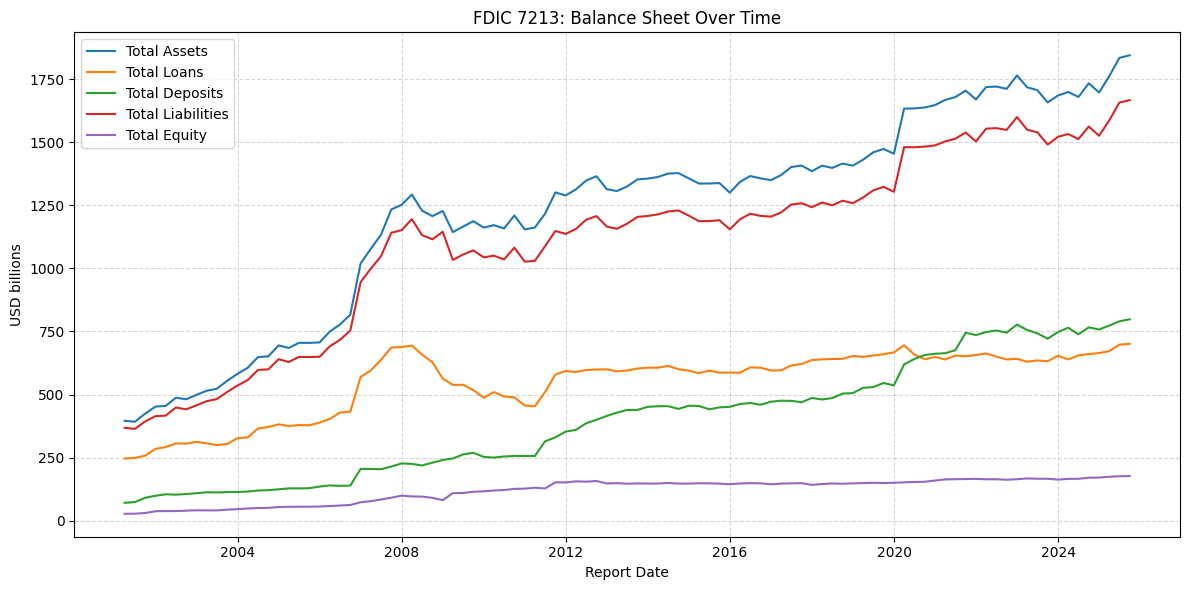

In [65]:
# Scale to USD billions (Call Report is in $ thousands)
panel["total_assets_bn"]            = panel["total_assets"] / 1e6
panel["total_loans_bn"]             = panel["total_loans"] / 1e6
panel["total_deposits_bn"]          = panel["total_deposits_domestic"] / 1e6  # <-- THIS is deposits
panel["total_liabs_minority_bn"]    = panel["total_liabs_minority"] / 1e6
panel["total_equity_bn"]            = panel["total_equity"] / 1e6

plt.figure(figsize=(12, 6))

plt.plot(panel["report_date"], panel["total_assets_bn"],         label="Total Assets")
plt.plot(panel["report_date"], panel["total_loans_bn"],          label="Total Loans")
plt.plot(panel["report_date"], panel["total_deposits_bn"],       label="Total Deposits")
plt.plot(panel["report_date"], panel["total_liabs_minority_bn"], label="Total Liabilities")
plt.plot(panel["report_date"], panel["total_equity_bn"],         label="Total Equity")

plt.title(f"FDIC {FDIC_CERT}: Balance Sheet Over Time")
plt.xlabel("Report Date")
plt.ylabel("USD billions")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [66]:
panel[
    [
        "report_date",
        "total_assets",
        "total_deposits",
        "total_deposits_domestic"
    ]
].tail()

,report_date,total_assets,total_deposits,total_deposits_domestic
94,2024-09-30,1733111000.0,591246000,766194000.0
95,2024-12-31,1696818000.0,567362000,757473000.0
96,2025-03-31,1760921000.0,588675000,772979000.0
97,2025-06-30,1833933000.0,623297000,790085000.0
98,2025-09-30,1844189000.0,631801000,798104000.0


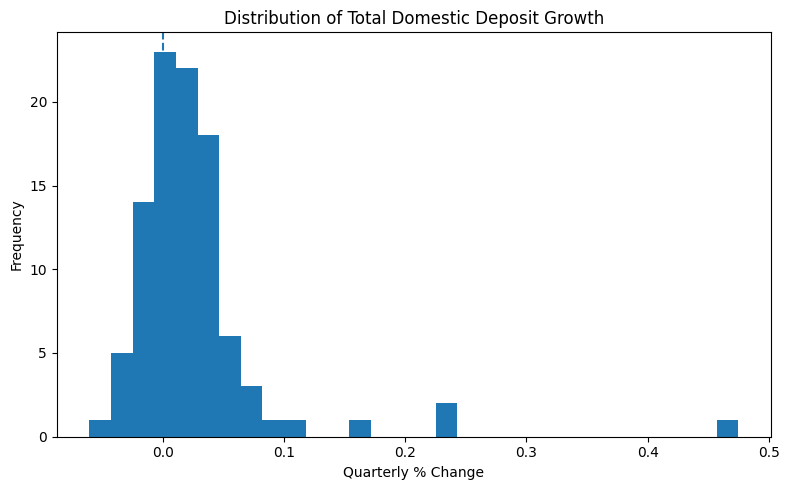

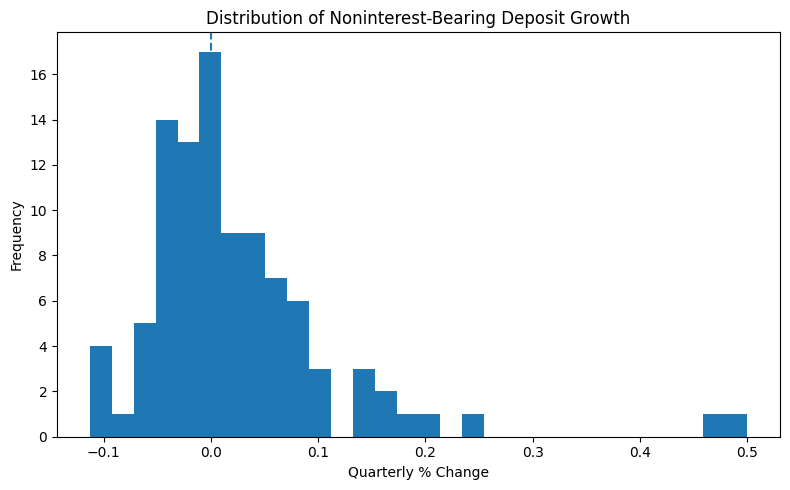

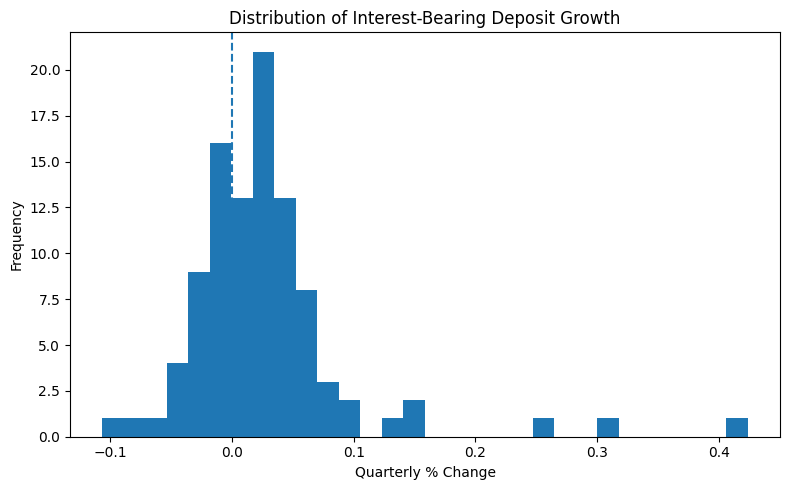

In [67]:
# -----------------------------
# Deposit growth / outflow measures
# -----------------------------

# Ensure proper time ordering
panel = panel.sort_values(["fdic_cert", "report_date"]).reset_index(drop=True)

# Total domestic deposits
panel["dep_total_pct"] = panel["total_deposits_domestic"].pct_change()

# Noninterest-bearing deposits (stickier)
panel["dep_nonint_pct"] = panel["nonint_deposits_domestic"].pct_change()

# Interest-bearing deposits (rate-sensitive)
panel["dep_int_pct"] = panel["intbearing_deposits_domestic"].pct_change()

# Optional: winsorize extreme values for stability (recommended)
for col in ["dep_total_pct", "dep_nonint_pct", "dep_int_pct"]:
    panel[col] = panel[col].clip(lower=-0.5, upper=0.5)


plt.figure(figsize=(8, 5))
plt.hist(panel["dep_total_pct"].dropna(), bins=30)
plt.title("Distribution of Total Domestic Deposit Growth")
plt.xlabel("Quarterly % Change")
plt.ylabel("Frequency")
plt.axvline(0, linestyle="--")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(panel["dep_nonint_pct"].dropna(), bins=30)
plt.title("Distribution of Noninterest-Bearing Deposit Growth")
plt.xlabel("Quarterly % Change")
plt.ylabel("Frequency")
plt.axvline(0, linestyle="--")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(panel["dep_int_pct"].dropna(), bins=30)
plt.title("Distribution of Interest-Bearing Deposit Growth")
plt.xlabel("Quarterly % Change")
plt.ylabel("Frequency")
plt.axvline(0, linestyle="--")
plt.tight_layout()
plt.show()


/var/folders/gw/gyqm76mn3d3_vjqrr211cp3m0000gn/T/ipykernel_23566/2282136860.py:29: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  .resample("Q")


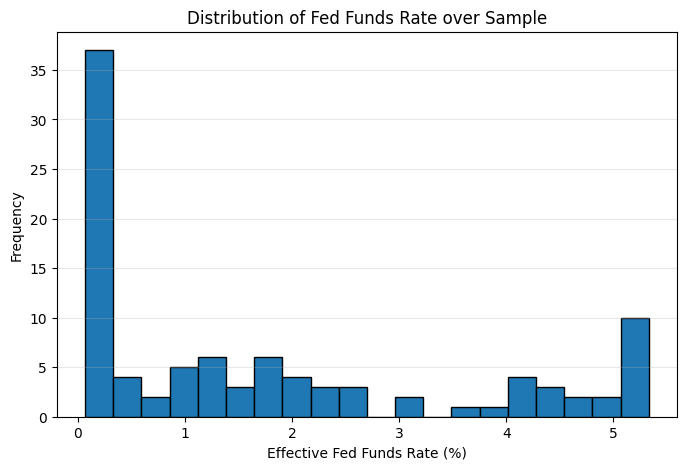

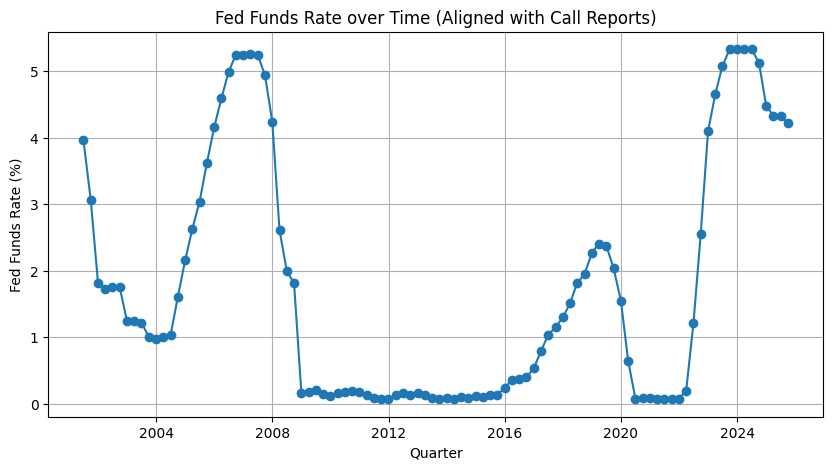

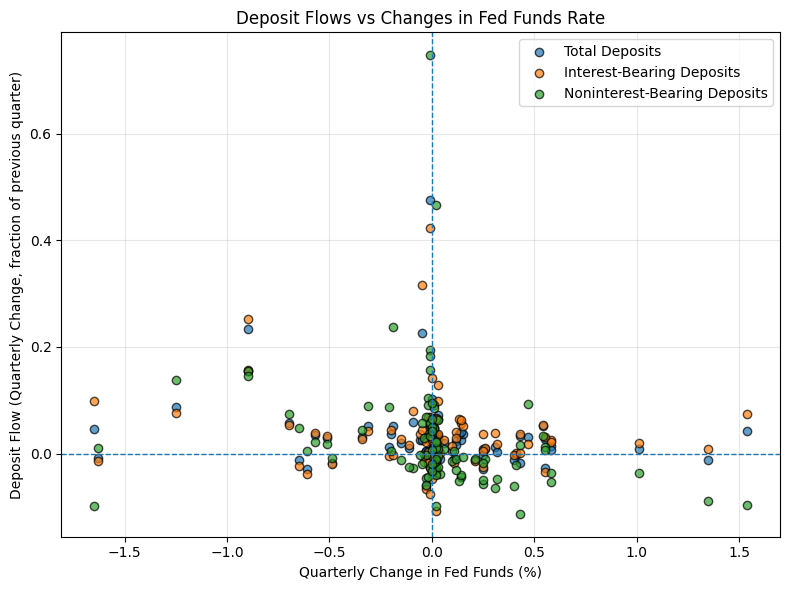

In [68]:
# ----------------------------------------------------
# 1. Deposit flows and outflows
# ----------------------------------------------------
panel = panel.sort_values("report_date").reset_index(drop=True)

# ----- FLOWS (symmetric) -----
panel["flow_total"] = panel["total_deposits_domestic"].pct_change()
panel["flow_int"]   = panel["intbearing_deposits_domestic"].pct_change()
panel["flow_nonint"] = panel["nonint_deposits_domestic"].pct_change()

# ----- OUTFLOWS (one-sided) -----
panel["outflow_total"] = -panel["flow_total"].clip(upper=0)
panel["outflow_int"]   = -panel["flow_int"].clip(upper=0)
panel["outflow_nonint"] = -panel["flow_nonint"].clip(upper=0)

# ----------------------------------------------------
# 2. Pull Fed funds, quarterly, aligned to Call dates
# ----------------------------------------------------
import datetime as dt
from pandas_datareader import data as pdr

start_date = panel["report_date"].min()
end_date   = panel["report_date"].max()

fed = pdr.DataReader("FEDFUNDS", "fred", start_date, end_date)

fed_q = (
    fed
    .resample("Q")
    .last()
)
fed_q.index = fed_q.index.to_period("Q").to_timestamp("Q")  # quarter-end dates

# Rename BEFORE merge so we only ever create 'fed_funds' once
fed_q = fed_q.rename(columns={"FEDFUNDS": "fed_funds"})

panel = panel.merge(
    fed_q,
    left_on="report_date",
    right_index=True,
    how="left"
)
panel = panel.loc[:, ~panel.columns.duplicated()]

# Quarterly change in Fed funds
panel["fedfunds_change"] = panel["fed_funds"].diff()

# ----------------------------------------------------
# 3. Fed funds level + changes: histograms and scatter
# ----------------------------------------------------
import matplotlib.pyplot as plt

# Histogram of Fed funds level
plt.figure(figsize=(8, 5))
plt.hist(panel["fed_funds"].dropna(), bins=20, edgecolor="black")
plt.xlabel("Effective Fed Funds Rate (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Fed Funds Rate over Sample")
plt.grid(True, axis="y", alpha=0.3)
plt.show()

# Time series of Fed funds
plt.figure(figsize=(10, 5))
plt.plot(panel["report_date"], panel["fed_funds"], marker="o")
plt.xlabel("Quarter")
plt.ylabel("Fed Funds Rate (%)")
plt.title("Fed Funds Rate over Time (Aligned with Call Reports)")
plt.grid(True)
plt.show()

# Histogram of quarterly change in Fed funds
plt.figure(figsize=(8, 6))

plt.scatter(
    panel["fedfunds_change"],
    panel["flow_total"],
    alpha=0.7,
    edgecolor="black",
    label="Total Deposits"
)

plt.scatter(
    panel["fedfunds_change"],
    panel["flow_int"],
    alpha=0.7,
    edgecolor="black",
    label="Interest-Bearing Deposits"
)

plt.scatter(
    panel["fedfunds_change"],
    panel["flow_nonint"],
    alpha=0.7,
    edgecolor="black",
    label="Noninterest-Bearing Deposits"
)

# Reference lines
plt.axhline(0, linestyle="--", linewidth=1)
plt.axvline(0, linestyle="--", linewidth=1)

plt.xlabel("Quarterly Change in Fed Funds (%)")
plt.ylabel("Deposit Flow (Quarterly Change, fraction of previous quarter)")
plt.title("Deposit Flows vs Changes in Fed Funds Rate")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Gaussian Copula

Gaussian copula correlation (rho): -0.2022658596412555


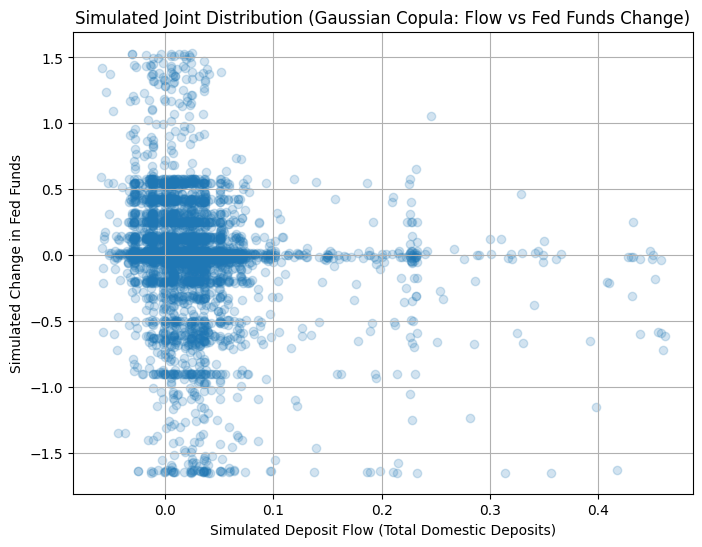

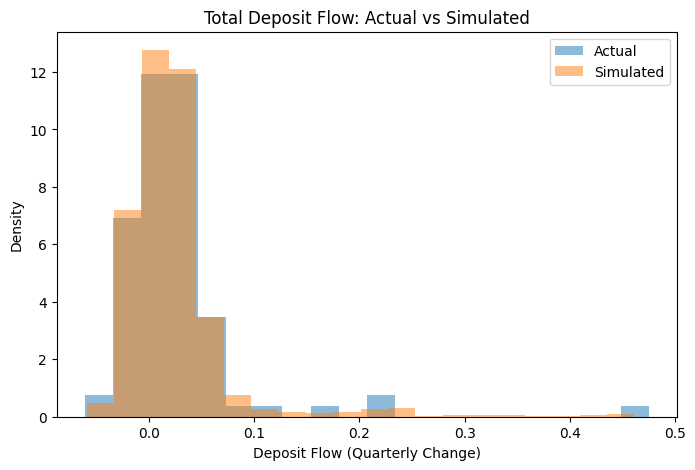

In [70]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# ----------------------------------------------------
# 1. Select variables: total deposit flow vs rate change
#    (assumes panel has 'flow_total' and 'fedfunds_change')
# ----------------------------------------------------
df = panel[["flow_total", "fedfunds_change"]].dropna().copy()

x = df["flow_total"].values        # quarterly deposit flow (∆ deposits / lagged deposits)
y = df["fedfunds_change"].values   # quarterly change in Fed funds (in same units as pulled)

n = len(df)

# ----------------------------------------------------
# 2. Rank-based empirical CDFs -> uniforms
# ----------------------------------------------------
u_x = (stats.rankdata(x, method="average") - 0.5) / n
u_y = (stats.rankdata(y, method="average") - 0.5) / n

# Avoid exact 0 / 1 for inverse normal
eps = 1e-6
u_x = np.clip(u_x, eps, 1 - eps)
u_y = np.clip(u_y, eps, 1 - eps)

# Map uniforms to standard normals
z_x = stats.norm.ppf(u_x)
z_y = stats.norm.ppf(u_y)

# ----------------------------------------------------
# 3. Estimate Gaussian copula correlation
# ----------------------------------------------------
rho = np.corrcoef(z_x, z_y)[0, 1]
print("Gaussian copula correlation (rho):", rho)

# ----------------------------------------------------
# 4. Simulate from the fitted Gaussian copula
# ----------------------------------------------------
num_sim = 5000

cov = np.array([[1,    rho],
                [rho,  1  ]])

# Simulated latent normals
z_sim = np.random.multivariate_normal(mean=[0.0, 0.0], cov=cov, size=num_sim)

# Back to uniforms
u_sim = stats.norm.cdf(z_sim)
u_x_sim = u_sim[:, 0]
u_y_sim = u_sim[:, 1]

def empirical_quantile(u, sample):
    return np.quantile(sample, u)

# Map simulated uniforms through empirical marginals
x_sim = empirical_quantile(u_x_sim, x)   # simulated flow_total
y_sim = empirical_quantile(u_y_sim, y)   # simulated fedfunds_change

# ----------------------------------------------------
# 5. Diagnostic plots
# ----------------------------------------------------
# Joint simulated cloud
plt.figure(figsize=(8, 6))
plt.scatter(x_sim, y_sim, alpha=0.2)
plt.xlabel("Simulated Deposit Flow (Total Domestic Deposits)")
plt.ylabel("Simulated Change in Fed Funds")
plt.title("Simulated Joint Distribution (Gaussian Copula: Flow vs Fed Funds Change)")
plt.grid(True)
plt.show()

# Compare marginals: actual vs simulated (deposit flow)
plt.figure(figsize=(8, 5))
plt.hist(x,     bins=20, alpha=0.5, label="Actual",     density=True)
plt.hist(x_sim, bins=20, alpha=0.5, label="Simulated", density=True)
plt.legend()
plt.title("Total Deposit Flow: Actual vs Simulated")
plt.xlabel("Deposit Flow (Quarterly Change)")
plt.ylabel("Density")
plt.show()

KeyError: 'outflow_rate'